# Intelligent Knowledge Graph - Data Exploration

Add some content

### Imports

In [22]:
import json
import pandas as pd
import os
import jsonlines
import networkx
import dgl
import cufflinks
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import OneHotEncoder
import copy
from gensim.models import Word2Vec 
import itertools
import umap
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


### Configs 

In [2]:
configs = {}
env_vars = {}


### Load Data 

In [3]:
def load_data(path, filename):
    
    filepath = os.path.join(path, filename) 
    print('Loading File from Path {}'.format(filepath))
    
    data = []
    with open(filepath, "r") as f:
        for l in f:
            data = l.replace('}{','}\n{')
    
    df = pd.read_json(data, lines=True)
    return df
    
df = load_data('../data','cleaned_related_skills.json')

Loading File from Path ../data/cleaned_related_skills.json


In [4]:
def data_summary(df, index_col):
    
    print('Dataframe shape {}'.format(df.shape))
    print('Dataframe Name Unique Rows {}'.format(df.groupby(index_col)[index_col].count().shape[0]))
    
    
data_summary(df, 'name')

Dataframe shape (28934, 11)
Dataframe Name Unique Rows 28934


### Insight 1:

Lets see the frequency of skills across the entire population. To do this we're goint to bin the skills into a new dataframe and then perform the counts



In [5]:
def skills_frequency(df, index_col):
    
    skills =[]
    cols = list(df.columns)
    cols.remove(index_col) 
    
    for idx,row in df.iterrows():
        
        for col in cols:
#             print(col)
            skills.append(row[col])
                
    df_dic = {'skills':skills}
    
    df_skills = pd.DataFrame(df_dic)
    
    return df_skills
    
    
df_skills = skills_frequency(df, 'name')
        
    

Total Non-unique Skills 289340
Unique Skills 28076
Pandas Describe:
         skills
count   289069
unique   28076
top          c
freq       588


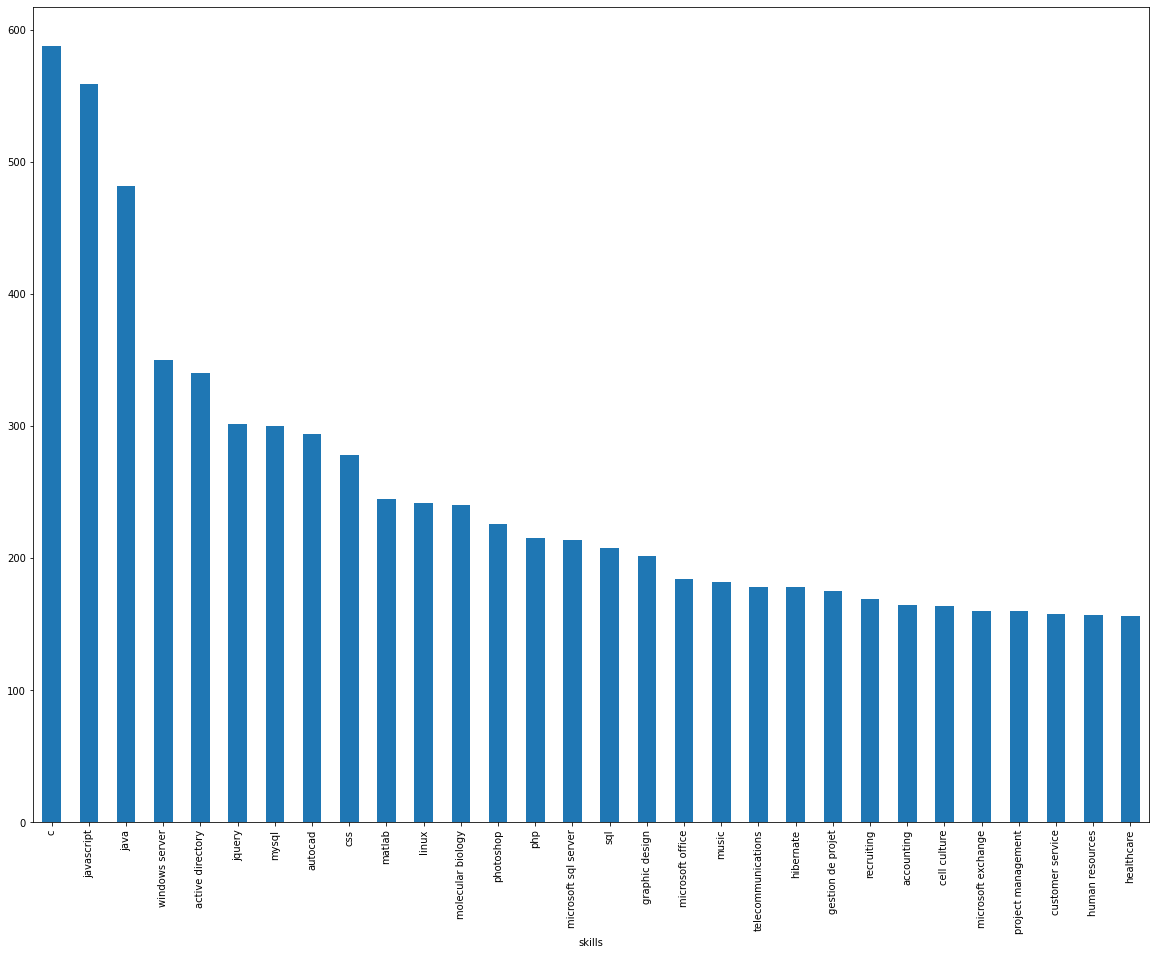

In [6]:
def plot_skills(df):
    
    col = 'skills'
        
    print('Total Non-unique Skills {}'.format(df.shape[0]))

    print('Unique Skills {}'.format(df.groupby(col).count().shape[0]))
    
    print('Pandas Describe:\n', df.describe())
    
    
    df.groupby('skills')['skills'].count().sort_values(ascending=False).head(30).plot(kind='bar', figsize=(20,15))

plot_skills(df_skills)

### Insight 2: Association Rule Mining

In [7]:
def transform_df_ohe(df, df_skills, index_col):
    
#     
    cols = list(df.columns)
    cols.remove(index_col)    

    datas = []
    for idx,row in df.iterrows():
        
        data = []
        for col in cols:
            data.append(str(row[col]))
        datas.append(data)
        
    te = TransactionEncoder()
    te_ary = te.fit(datas).transform(datas)

    df_ohe = pd.DataFrame(te_ary, columns=te.columns_)
    
    return df_ohe

df_ohe = transform_df_ohe(df, df_skills,'name')

In [8]:
def calc_aprior(df, min_support= 0.6, max_len=None):
    
    freq_items = apriori(df, min_support=min_support, max_len=max_len, use_colnames=True, verbose=1)
    return freq_items

freq_items = calc_aprior(df_ohe, min_support= 0.006, max_len=None)

Processing 51 combinations | Sampling itemset size 3


In [9]:
freq_items['length'] = freq_items['itemsets'].apply(lambda x: len(x))
freq_items

,support,itemsets,length
0,0.011751,(active directory),1
1,0.010161,(autocad),1
2,0.020322,(c),1
3,0.009608,(css),1
4,0.006048,(gestion de projet),1
5,0.006981,(graphic design),1
6,0.006152,(hibernate),1
7,0.016659,(java),1
8,0.019320,(javascript),1
9,0.010438,(jquery),1


In [10]:
def association_rule_gen(freq_items):
    
    rules = association_rules(freq_items, metric="lift", min_threshold=0.0001)
    
    display(rules.head(20))
    
association_rule_gen(freq_items)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(windows server),(active directory),0.012096,0.011751,0.009850,0.814286,69.295714,0.009708,5.321341
1,(active directory),(windows server),0.011751,0.012096,0.009850,0.838235,69.295714,0.009708,6.107040
2,(javascript),(css),0.019320,0.009608,0.007707,0.398927,41.519942,0.007522,1.647706
3,(css),(javascript),0.009608,0.019320,0.007707,0.802158,41.519942,0.007522,4.956892
4,(jquery),(css),0.010438,0.009608,0.007534,0.721854,75.129973,0.007434,3.560695
5,(css),(jquery),0.009608,0.010438,0.007534,0.784173,75.129973,0.007434,4.584973
6,(javascript),(java),0.019320,0.016659,0.007051,0.364937,21.906843,0.006729,1.548416
7,(java),(javascript),0.016659,0.019320,0.007051,0.423237,21.906843,0.006729,1.700316
8,(javascript),(jquery),0.019320,0.010438,0.009712,0.502683,48.161061,0.009510,1.989804
9,(jquery),(javascript),0.010438,0.019320,0.009712,0.930464,48.161061,0.009510,14.103115


### Insight 3: Word2Vec

In [35]:
#Lets create all the combinations from a given list...
def transform_into_combinations(df, df_skills, index_col):
    
#     
    cols = list(df.columns)
    cols.remove(index_col)    

    datas = []
    for idx,row in df.iterrows():
        data = []
        for col in cols:
            data.append(str(row[col]))
        datas.append(data)
        
    #now for each row, generate the combinations
    train = []
    for row in datas:
        all_combins = []
#         for i in range(2,3):
#             print(i)
        combins = list(itertools.combinations(row, 2))
        for entry in combins:
            all_combins.append(list(entry))
#         print(all_combins)
        train.append(list(itertools.chain(*all_combins)))
    return datas

    


w2c_train = transform_into_combinations(df, df_skills, 'name')

In [36]:
def build_w2v_model(train_data):
    
    model = Word2Vec(window = 10, 
                     sg = 1, hs = 0,
                     negative = 10, # for negative sampling
                     alpha=0.03, min_alpha=0.0007,
                     seed = 10,
                     min_count=50)
    
    model.build_vocab(train_data, progress_per=200)

    
    model.train(train_data, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)
    
    return model

In [37]:
w2v_model = build_w2v_model(w2c_train)

In [38]:
w2v_model.init_sims(replace=True)


In [39]:
print(w2v_model)


Word2Vec(vocab=373, size=100, alpha=0.03)


/Users/ramine.tinati/anaconda3/envs/gpu-tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



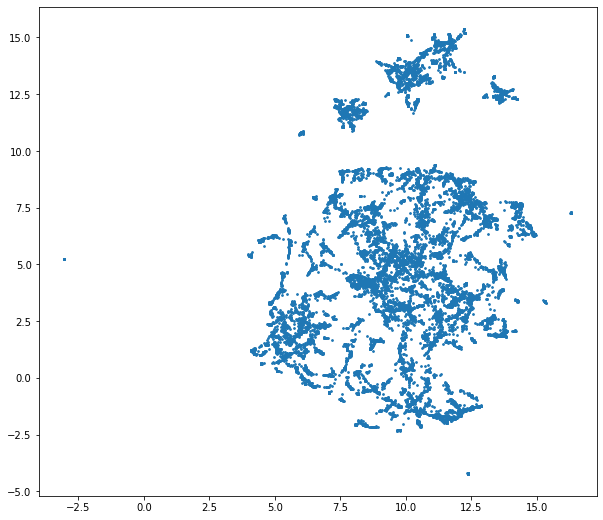

In [33]:
def visualize_model(model):
    
    X = w2v_model[w2v_model.wv.vocab]
    X.shape

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                                  n_components=2, random_state=42).fit_transform(X)
    
    
#     x = []
#     y = []
#     for value in new_values:
#         x.append(value[0])
#         y.append(value[1])

    plt.figure(figsize=(10,9))
    plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')
    
    
visualize_model(w2v_model)

/Users/ramine.tinati/anaconda3/envs/gpu-tf/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Indexed 373 samples in 0.010s...
[t-SNE] Computed neighbors for 373 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 373 / 373
[t-SNE] Mean sigma: 0.119201
[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.086731
[t-SNE] KL divergence after 4650 iterations: 0.981002
Total Tokens 373


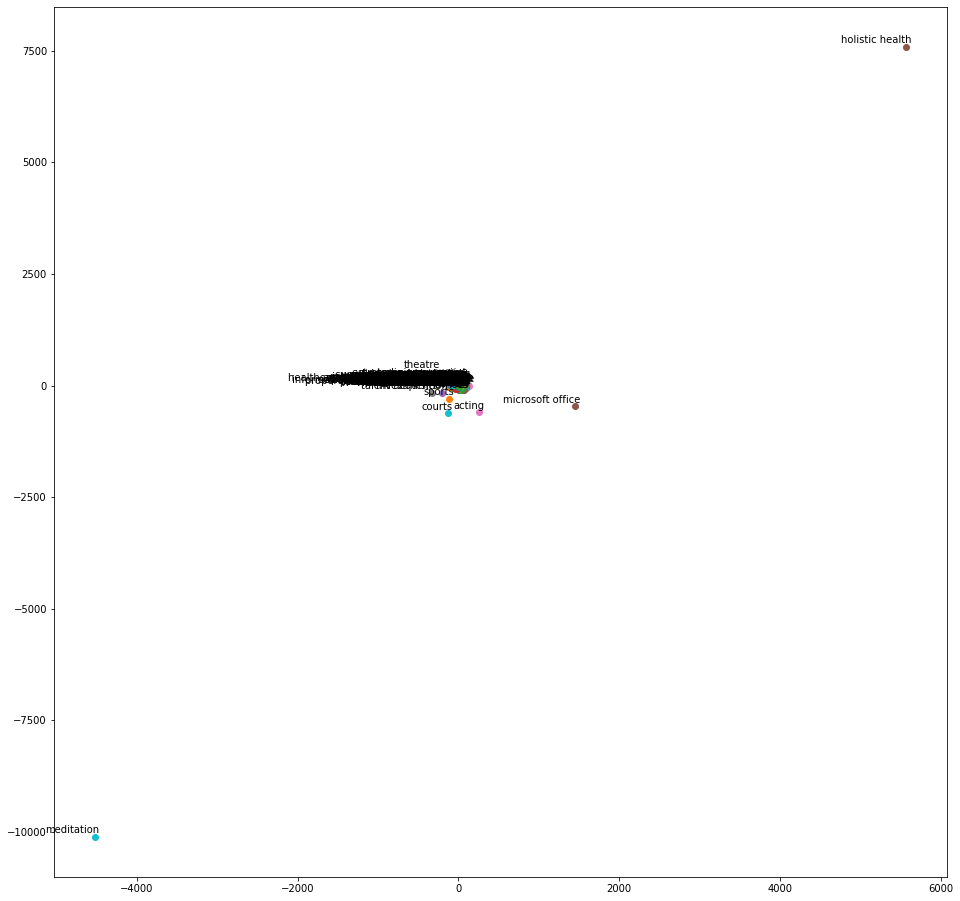

In [42]:
def evaluate_model_results(model):
    
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    
    #cheapest way to find maximum number of vectors to generate our TSNE representations

    tsne = TSNE(perplexity=4, n_components=3, init='pca', n_iter=10000, verbose=1)
    
    new_values = tsne.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    print('Total Tokens {}'.format(len(labels)))

    plt.figure(figsize=(16, 16)) 
    
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()    
    

#     return two_d_embeddings, labels

evaluate_model_results(w2v_model)

In [ ]:
def w2v_calc_similarity(vector)